In [3]:
import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt

%matplotlib inline
pd.options.display.max_columns = 100

# font check
from matplotlib import font_manager as fm
for font in fm.fontManager.ttflist:
    if 'Pretendard' in font.name:
        print(font.name, font.fname)

# fe = fm.FontEntry(
#     fname=r'C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard.ttf', # ttf 파일이 저장되어 있는 경로
#     name='Pretendard')                       
# fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
# plt.rcParams.update({'font.size': 10, 'font.family': 'Pretendard'})

plt.rcParams['font.family'] = 'Pretendard'

Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-SemiBold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Bold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Regular.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Black.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Medium.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-ExtraLight.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Light.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-ExtraBold.ttf
Pretendard C:\Users\FELAB\AppData\Local\Microsoft\Windows\Fonts\Pretendard-Thin.ttf


In [ ]:
# 상장폐지 및 특수사례 제거
open_path = './_SNP_dataset/market_by_exchange'
save_path = './_SNP_dataset/market_by_exchange_FullPricingDate'
os.makedirs(save_path, exist_ok=True)  # Create the save directory if it doesn't exist
exchange = pd.read_csv('./_SNP_dataset/market_by_exchange/_exchangeSymbol.csv')

for i in exchange['exchange']:  # Replace 'column_name' with the actual column name
    file_path = f'{open_path}/{i}.parquet'
    if os.path.exists(file_path):  # Check if the file exists
        df = pd.read_parquet(file_path, engine='fastparquet')
        count = df.groupby('tickerSymbol').count()
        threshold = count['companyId'].describe()['75%'] # 특수사례 기준점
        count = count[count['companyId'] >= threshold]
        df = df[df['tickerSymbol'].isin(count.index)]
        df.to_parquet(f'{save_path}/{i}_FullPricingDate.parquet')
    else:
        print(f"File not found: {file_path}")

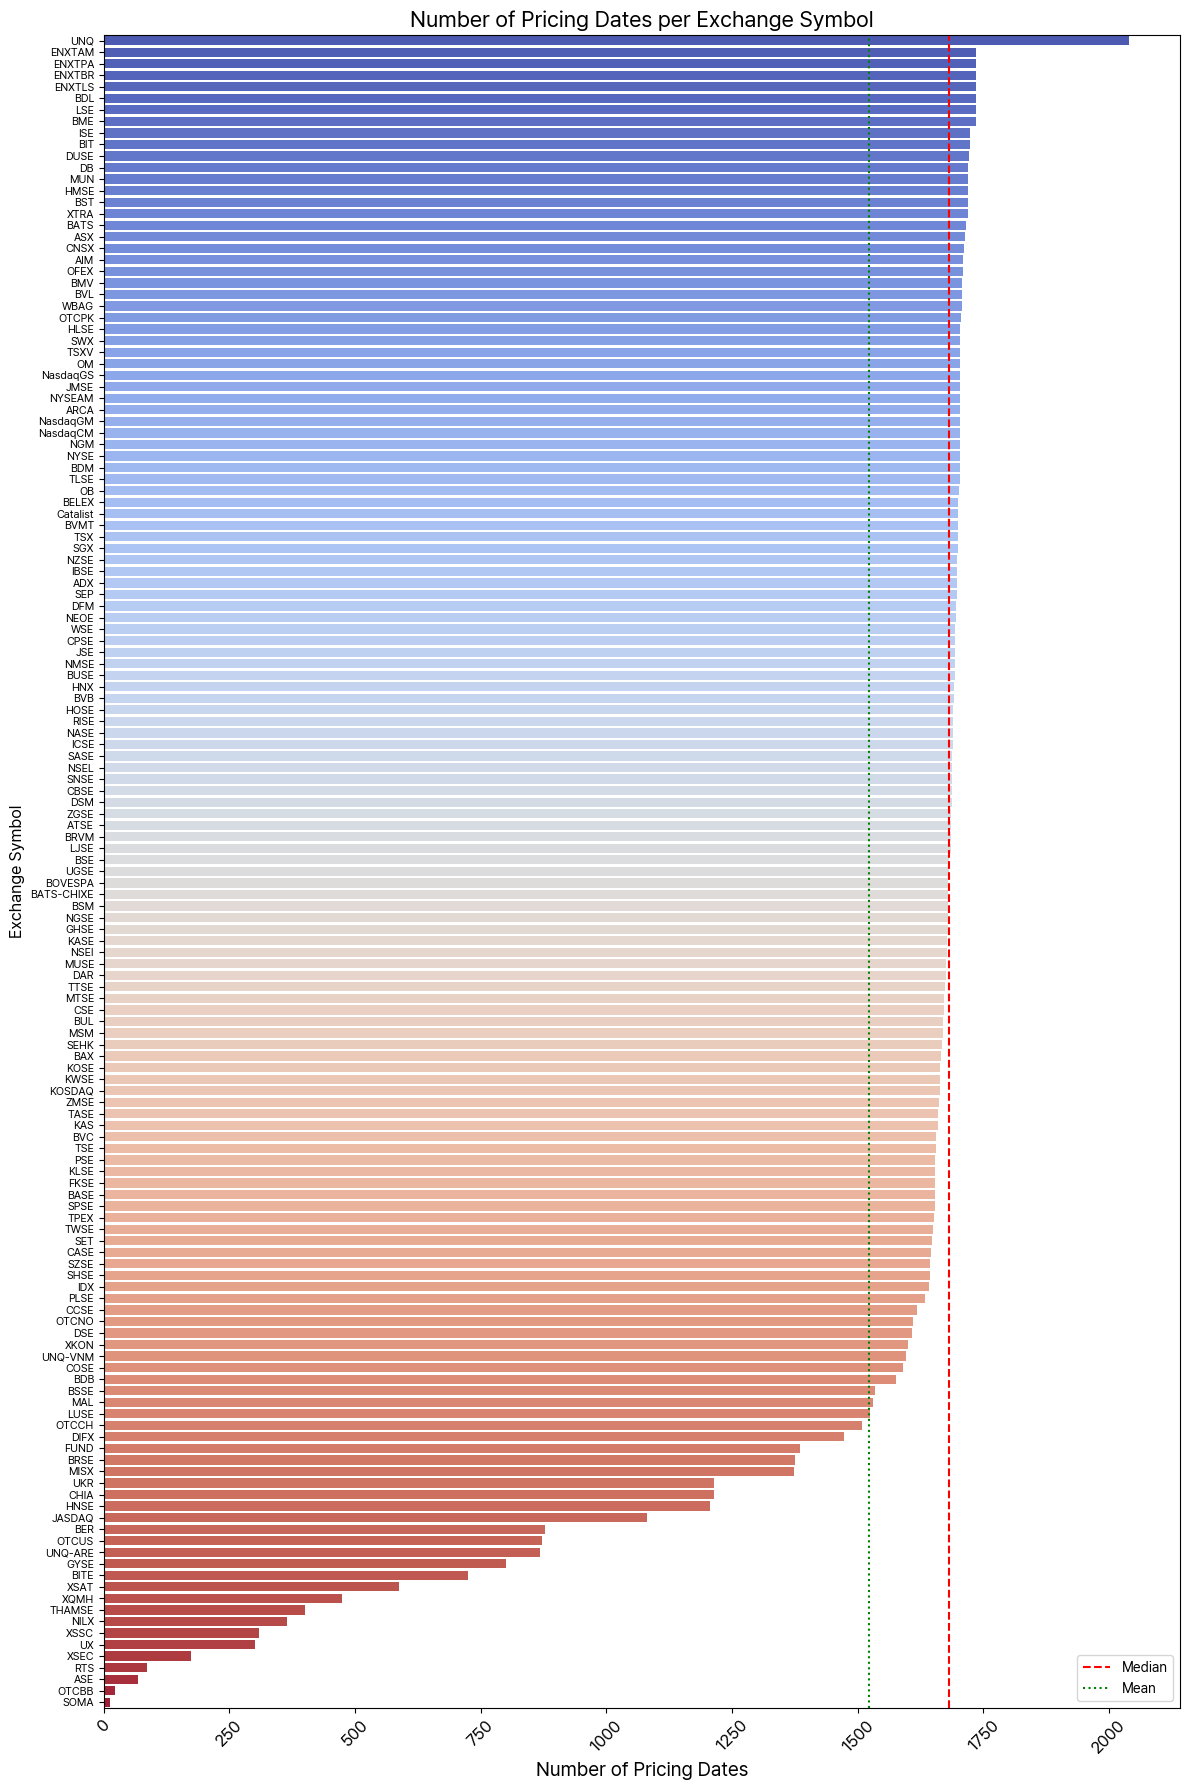

In [4]:
%matplotlib inline
path = f'./_SNP_dataset\market_by_exchange_FullPricingDate'
df = pd.read_parquet(f'{path}/market_FullPricingDate.parquet', engine='fastparquet')
temp = df.groupby('exchangeSymbol')['pricingDate'].unique()
# Assuming 'exchange_data' is your DataFrame with the series of dates
exchange_data = pd.DataFrame(temp)  # Replace with your actual DataFrame
exchange_data = exchange_data.reset_index()

# Initialize an empty DataFrame for the final output
all_exchanges_df = pd.DataFrame()

for index, row in exchange_data.iterrows():
    # Extract exchange symbol and pricing dates
    exchange_symbol = row['exchangeSymbol']
    pricing_dates = row['pricingDate']

    # Create a temporary DataFrame for this exchange
    temp_df = pd.DataFrame({
        'exchangeSymbol': exchange_symbol,
        'pricingDate': pricing_dates
    })

    # Concatenate with the main DataFrame
    all_exchanges_df = pd.concat([all_exchanges_df, temp_df], ignore_index=True)

exchange_data = all_exchanges_df
exchange_data['pricingDate'] = pd.to_datetime(exchange_data['pricingDate'])
date_counts = exchange_data.groupby('exchangeSymbol')['pricingDate'].count().reset_index().sort_values(by='pricingDate', ascending=False)

plt.figure(figsize=(12, 18))  # Increased width
barplot = sns.barplot(data=date_counts, y='exchangeSymbol', x='pricingDate', palette="coolwarm", hue='exchangeSymbol')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=8)
plt.axvline(x=date_counts['pricingDate'].median(), color='red', linestyle='--', label='Median')
plt.axvline(x=date_counts['pricingDate'].mean(), color='green', linestyle=':', label='Mean')
plt.xlabel('Number of Pricing Dates', fontsize=14)
plt.ylabel('Exchange Symbol', fontsize=12)
plt.title('Number of Pricing Dates per Exchange Symbol', fontsize=16)
plt.legend()
plt.tight_layout()